In [75]:
import sys, subprocess
subprocess.run([sys.executable, "-m", "pip", "install", "matplotlib", "-q"])
print("✓ matplotlib установлен")


✓ matplotlib установлен


In [2]:
import os, pathlib, textwrap, importlib.metadata as md

print("⮕  Переменная окружения FMP_API_KEY:",
      os.getenv("FMP_API_KEY", "<не установлена>"))

cred_path = pathlib.Path.home() / ".openbb" / "credentials.toml"
print("⮕  Файл ~/.openbb/credentials.toml существует?", cred_path.exists())

if cred_path.exists():
    print("⮕  Содержимое файла:")
    print(textwrap.indent(cred_path.read_text(), "    "))

# теперь уже импортируем openbb
from openbb import obb
print("⮕  OpenBB version:", md.version("openbb"))

try:
    df = obb.equity.profile("AAPL", provider="fmp")
    print("✅  Запрос прошёл, первые строки:")
    display(df.head())
except Exception as e:
    print("❌  Ошибка:", e)


⮕  Переменная окружения FMP_API_KEY: <не установлена>
⮕  Файл ~/.openbb/credentials.toml существует? True
⮕  Содержимое файла:
    fmp_api_key = "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC"

⮕  OpenBB version: 4.4.4
❌  Ошибка: 
[Error] -> Missing credential 'fmp_api_key'. Check https://financialmodelingprep.com to get it. Known more about how to set provider credentials at https://docs.openbb.co/platform/getting_started/api_keys.


In [3]:
# правильный способ
profile_obj = obb.equity.profile("AAPL", provider="fmp")

# 1) получить чистый pandas-DataFrame
df = profile_obj.to_df()        # или:  df = profile_obj.data
df.head()


OpenBBError: 
[Error] -> Missing credential 'fmp_api_key'. Check https://financialmodelingprep.com to get it. Known more about how to set provider credentials at https://docs.openbb.co/platform/getting_started/api_keys.

In [ ]:
import importlib.metadata as md, openbb
print(md.version("openbb"))


In [ ]:
import sys, yfinance, yaml, pandas, pyarrow
print("Импорты прошли! Работаю из", sys.executable)



In [ ]:
import pathlib
pathlib.Path("data/raw").mkdir(parents=True, exist_ok=True)
print("Папка data/raw готова!")


In [ ]:
import pandas as pd, yaml, requests

url = "https://gist.githubusercontent.com/ZeccaLehn/f6a2613b24c393821f81c0c1d23d4192/raw/SP500.csv"
sp500 = pd.read_csv(url)
tickers = sorted(sp500["Symbol"].unique())

with open("universe.yaml", "w") as f:
    yaml.safe_dump({"tickers": tickers}, f)

print(f"{len(tickers)} tickers saved to universe.yaml")


In [ ]:
import yfinance as yf, yaml, pandas as pd, pathlib

pathlib.Path("data/raw").mkdir(parents=True, exist_ok=True)

tickers = yaml.safe_load(open("universe.yaml"))["tickers"]
prices = yf.download(tickers,
                     start="2015-01-01",
                     auto_adjust=True,
                     progress=False)["Close"]

prices.to_parquet("data/raw/prices.parquet")
print("Saved", prices.shape, "to data/raw/prices.parquet")


In [ ]:
import pathlib, pandas as pd

prices = pd.read_parquet("data/raw/prices.parquet")
print("Before drop:", prices.shape)

all_nan = prices.isna().all()
prices = prices.loc[:, ~all_nan]

print("After drop :", prices.shape)

# ---- вот эта строка создаст папку, если её нет ----
pathlib.Path("data/processed").mkdir(parents=True, exist_ok=True)

prices.to_parquet("data/processed/prices_raw_clean.parquet")
print("Файл сохранён!")


In [ ]:
prices = pd.read_parquet("data/raw/prices.parquet")
print("Before drop:", prices.shape)

all_nan = prices.isna().all()
prices = prices.loc[:, ~all_nan]

print("After drop :", prices.shape)
prices.to_parquet("data/processed/prices_raw_clean.parquet")


In [ ]:
prices = prices.sort_index()          # вдруг даты перемешались
prices = prices.ffill().bfill()       # вперёд/назад заполнение

# sanity-check
assert prices.isna().sum().sum() == 0, "Остались пропуски!"

prices.to_parquet("data/processed/prices_filled.parquet")


In [ ]:
returns = prices.pct_change().dropna(how="all")
returns.to_parquet("data/processed/returns.parquet")
print("Returns shape:", returns.shape)


In [ ]:
print("Mean daily return:", returns.mean().mean().round(4))
print("Mean daily volatility:", returns.std().mean().round(4))


In [ ]:
import openbb                # ← корневой пакет
from openbb import obb       # ← объект-“приложение”

print("OpenBB version:", openbb.__version__)   # ✓ так работает
# или просто пропустите проверку версии

# запишем ключ FMP
obb.user.set_apikey("fmp", "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC")   # токен лучше сразу сменить
obb.user.save_settings()                       # сохранит в ~/.openbb

print("Ключ сохранён:", obb.user.get_apikey("fmp")[:4]+"…")


In [ ]:
# --- импортируем ---
from openbb import obb                    # главный объект-«приложение»
import importlib.metadata as md           # стандартный модуль Python ≥3.8

# безопасно узнаём версию пакета (если очень хочется)
try:
    ver = md.version("openbb")
    print("OpenBB version:", ver)
except md.PackageNotFoundError:
    print("OpenBB: версия не объявлена, но пакет загружен")

# --- прописываем FMP-ключ ---
obb.user.set_apikey("fmp", "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC")   # лучше сразу регенерировать
obb.user.save_settings()
print("Ключ сохранён локально!")

# --- быстрая проверка: профиль Apple ---
df = obb.equity.profile("AAPL", provider="fmp")
display(df.head())


In [ ]:
import os
# ❗️ вставьте НОВЫЙ сгенерированный токен – тот, что был на скрине, лучше уже заменить
os.environ["FMP_API_KEY"] = "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC"


In [ ]:
import pathlib, os, textwrap, sys

cred_path = pathlib.Path.home() / ".openbb" / "credentials.toml"
print("Ожидаемый путь:", cred_path)
print("Файл существует? ➜", cred_path.exists())

if cred_path.exists():
    print("\nСодержимое файла:")
    print(textwrap.indent(cred_path.read_text(), "    "))


In [ ]:
fmp_api_key = "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC"


In [ ]:
from openbb import obb
obb.equity.profile("AAPL", provider="fmp").head()


In [5]:
# если ещё не сделали в терминале
# conda activate stocks

import sys, subprocess, importlib, pathlib, os
REQ = ["yfinance", "openbb", "pandas", "pyarrow", "tqdm"]
subprocess.run([sys.executable, "-m", "pip", "install", *REQ, "-q"])
print("✓ все пакеты установлены/актуальны")


✓ все пакеты установлены/актуальны


In [7]:
from pathlib import Path
for p in ["data/raw", "data/processed", "reports/figures"]:
    Path(p).mkdir(parents=True, exist_ok=True)
print("✓ создано: data/raw  data/processed  reports/figures")


✓ создано: data/raw  data/processed  reports/figures


In [9]:
import pandas as pd

url = "https://gist.githubusercontent.com/ZeccaLehn/"\
      "f6a2613b24c393821f81c0c1d23d4192/raw/SP500.csv"
tickers = pd.read_csv(url)["Symbol"].sort_values().tolist()

pd.Series(tickers, name="tickers").to_csv("universe.csv", index=False)
print(f"✓ сохранено {len(tickers)} тикеров → universe.csv")


✓ сохранено 505 тикеров → universe.csv


In [11]:
import yfinance as yf

prices = yf.download(
    tickers,
    start="2015-01-01",
    auto_adjust=True,  # Close уже скорректирован
    progress=False)["Close"]

prices.to_parquet("data/raw/prices.parquet")
print("✓ prices.parquet", prices.shape)



77 Failed downloads:
['ADS', 'CBS', 'XL', 'CXO', 'AGN', 'BRK.B', 'XEC', 'FB', 'VAR', 'FISV', 'JEC', 'SYMC', 'ARNC', 'ETFC', 'PBCT', 'WRK', 'BHGE', 'TSS', 'VIAB', 'XLNX', 'CTL', 'LLL', 'WLTW', 'ALXN', 'TIF', 'DISH', 'HCP', 'PKI', 'NBL', 'DWDP', 'ATVI', 'DRE', 'MRO', 'UTX', 'GPS', 'ABC', 'DISCK', 'PXD', 'RHT', 'CHK', 'CERN', 'RE', 'BLL', 'FLIR', 'COG', 'MON', 'DISCA', 'BBT', 'FBHS', 'CELG', 'MYL', 'APC', 'TMK', 'RTN', 'NLSN', 'ANTM', 'CTXS', 'HRS', 'KSU']: YFTzMissingError('possibly delisted; no timezone found')
['AET', 'SCG', 'ANDV', 'TWX', 'CSRA']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')
['WYN', 'GGP', 'KORS', 'CBG', 'LUK', 'SNI', 'BF.B', 'PCLN', 'DPS', 'HCN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-05-22)')
['KMB']: Timeout('Failed to perform, curl: (28) Connection timed out after 916269 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['MAT']: Timeou

✓ prices.parquet (2612, 505)


In [15]:
# 4.1   убираем столбцы, где все NaN
prices = prices.loc[:, ~prices.isna().all()]
# 4.2   заполняем одиночные пропуски
prices = prices.ffill().bfill()

prices.to_parquet("data/processed/prices_filled.parquet")

# 4.3   дневные доходности
returns = prices.pct_change().dropna(how="all")
returns.to_parquet("data/processed/returns.parquet")

print("✓ prices_filled.parquet", prices.shape)
print("✓ returns.parquet", returns.shape)



✓ prices_filled.parquet (2612, 428)
✓ returns.parquet (2611, 428)


In [19]:
from openbb import obb
from pathlib import Path
import json

# 1 — задать (или снова задать) ключ как строку
KEY = "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC"   # ← ваш реальный токен
obb.user.credentials.fmp_api_key = KEY

# 2 — сохранить в ~/.openbb_platform/user_settings.json
settings_file = Path.home() / ".openbb_platform" / "user_settings.json"
settings_file.parent.mkdir(parents=True, exist_ok=True)

data = {"credentials": {"fmp_api_key": KEY}}  # обычная строка
with open(settings_file, "w") as f:
    json.dump(data, f, indent=2)

print("✓ ключ сохранён в", settings_file)


✓ ключ сохранён в /Users/malekamerzhoeva/.openbb_platform/user_settings.json


In [21]:
from openbb import obb
df = obb.equity.profile("AAPL", provider="fmp").to_df()
df.head()          # должна появиться таблица без ошибок


,symbol,name,cik,cusip,isin,stock_exchange,long_description,ceo,company_url,business_phone_no,...,is_fund,image,currency,market_cap,last_price,year_high,year_low,volume_avg,annualized_dividend_amount,beta
0,AAPL,Apple Inc.,0000320193,037833100,US0378331005,NASDAQ Global Select,"Apple Inc. designs, manufactures, and markets ...",Mr. Timothy D. Cook,https://www.apple.com,(408) 996-1010,...,False,https://images.financialmodelingprep.com/symbo...,USD,3018375822000,202.09,260.1,169.21,61490677,1.01,1.275


In [25]:
from openbb import obb
from pathlib import Path
import json

settings_file = Path.home() / ".openbb_platform" / "user_settings.json"
settings_file.parent.mkdir(exist_ok=True)

# способ 1 — строка из переменной
json.dump({"credentials": {"fmp_api_key": "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC"}},
          open(settings_file, "w"), indent=2)

# способ 2 — извлекаем из SecretStr
# json.dump({"credentials": {"fmp_api_key":
#            obb.user.credentials.fmp_api_key.get_secret_value()}},
#           open(settings_file, "w"), indent=2)

print("Файл перезаписан:", settings_file)


Файл перезаписан: /Users/malekamerzhoeva/.openbb_platform/user_settings.json


In [36]:
import requests, pandas as pd, time, pathlib

API_KEY  = "zqeoRJ2nkCUIYhe6q6tRLSTzePdObTuC"
tickers  = prices.columns.tolist()
OUTFILE  = pathlib.Path("data/raw/profile.parquet")

def get_profiles_batch(symbols):
    """Возвращает DataFrame профилей для списка тикеров."""
    syms = ",".join(symbols)
    url  = f"https://financialmodelingprep.com/api/v3/profile/{syms}?apikey={API_KEY}"
    data = requests.get(url, timeout=15).json()

    # если API прислало словарь-ошибку, а не список
    if isinstance(data, dict) and data.get("Error Message"):
        raise RuntimeError(data["Error Message"])

    return pd.DataFrame(data)

profiles = []
CHUNK = 50                              # <= 50 тикеров в одном запросе
for i in range(0, len(tickers), CHUNK):
    batch = tickers[i : i + CHUNK]

    # 3 попытки, если словили временный отказ
    for attempt in range(3):
        try:
            df = get_profiles_batch(batch)
            if not df.empty:
                profiles.append(df)
            break                       # успешно – выходим из retry-цикла
        except RuntimeError as e:
            print(f"batch {batch[:3]}… ->", e)
            time.sleep(30)              # ждём и пробуем снова
    time.sleep(12)                      # 5 запросов/мин — безопасно

# проверка: вдруг ни один запрос не прошёл
if profiles:
    pd.concat(profiles, ignore_index=True).to_parquet(OUTFILE)
    print("✓ profile.parquet сохранён —", OUTFILE, "строк:", sum(len(p) for p in profiles))
else:
    print("⚠️  Не удалось получить ни одного профиля. Проверьте ключ и лимиты.")


batch ['A', 'AAL', 'AAP']… -> Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/
batch ['A', 'AAL', 'AAP']… -> Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/
batch ['A', 'AAL', 'AAP']… -> Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/
batch ['BAC', 'BAX', 'BBY']… -> Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/
batch ['BAC', 'BAX', 'BBY']… -> Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/


KeyboardInterrupt: 

In [38]:
import pandas as pd

table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", header=0)[0]
sector_map = table[["Symbol", "GICS Sector", "GICS Sub-Industry"]]\
                 .rename(columns={"Symbol":"symbol",
                                  "GICS Sector":"sector",
                                  "GICS Sub-Industry":"industry"})

sector_map.to_parquet("data/raw/profile.parquet")
print("✓ profile.parquet", sector_map.shape)


✓ profile.parquet (503, 3)


In [46]:
API_KEY = "9xiVYC5dKHY8WusNEHAAKNrQFiufUE6N"  # ваша переменная со строкой-ключом

def get_ratios_batch(chunk):
    syms = ",".join(chunk)
    url  = f"https://financialmodelingprep.com/api/v3/ratios-ttm/{syms}?apikey={API_KEY}"
    data = requests.get(url, timeout=15).json()
    if isinstance(data, dict) and data.get("Error Message"):
        raise RuntimeError(data["Error Message"])
    return pd.DataFrame(data)

fund = []
for i in range(0, len(tickers), 50):
    batch = tickers[i : i + 50]
    for attempt in range(3):
        try:
            df = get_ratios_batch(batch)
            if not df.empty:
                fund.append(df.assign(symbol=lambda d: batch))
            break
        except RuntimeError as e:
            print(f"batch {batch[:3]}… ->", e)
            time.sleep(30)
    time.sleep(12)

if fund:
    result = pd.concat(fund, ignore_index=True)
    result.to_parquet("data/raw/fundamentals.parquet")
    print("✓ fundamentals.parquet сохранён:", result.shape)
else:
    print("⚠️ Не удалось получить ни одной пачки данных — проверьте лимиты и ключ.")


⚠️ Не удалось получить ни одной пачки данных — проверьте лимиты и ключ.


In [59]:
import pandas as pd, pathlib

# 1) проверяем наличие
raw = pathlib.Path("data/raw")
proc = pathlib.Path("data/processed")

# файлы с ценами и доходностями обязательно есть
assert raw.joinpath("prices.parquet").exists()
assert proc.joinpath("prices_filled.parquet").exists()
assert proc.joinpath("returns.parquet").exists()
assert raw.joinpath("profile.parquet").exists()

# 2) загружаем
prices    = pd.read_parquet(raw / "prices.parquet")
prices_f  = pd.read_parquet(proc / "prices_filled.parquet")
returns   = pd.read_parquet(proc / "returns.parquet")
profile   = pd.read_parquet(raw / "profile.parquet")

# 3) пробуем фундаментал, иначе пустой DF
fund_path = raw / "fundamentals.parquet"
if fund_path.exists():
    fundament = pd.read_parquet(fund_path)
else:
    fundament = pd.DataFrame()
    print("⚠️  Файл fundamentals.parquet не найден — пропускаем merge фундаментала.")

# 4) размеры
print(
    "shapes:",
    "prices", prices.shape,
    "prices_f", prices_f.shape,
    "returns", returns.shape,
    "profile", profile.shape,
    "fundament", fundament.shape,
)


⚠️  Файл fundamentals.parquet не найден — пропускаем merge фундаментала.
shapes: prices (2612, 505) prices_f (2612, 428) returns (2611, 428) profile (503, 3) fundament (0, 0)


In [61]:
# 2. Переводим цены и доходности в длинный формат
prices_long = (
    prices_f
    .reset_index()                             # перевести индекс Date в колонку
    .melt(id_vars="Date", 
          var_name="symbol", 
          value_name="price")
)

returns_long = (
    returns
    .reset_index()
    .melt(id_vars="Date", 
          var_name="symbol", 
          value_name="return")
)

print("prices_long:", prices_long.shape)
print("returns_long:", returns_long.shape)

# 3. Склеиваем цены и доходности
df = prices_long.merge(
    returns_long, on=["Date","symbol"], how="left"
)
print("После merge price+return:", df.shape)

# 4. Добавляем сектор/индустрию
df = df.merge(
    profile, on="symbol", how="left"
)
print("После merge profile:", df.shape)

# Проверка отсутствия секторов (должно быть 0)
print("Нет секторов для строк:", df["sector"].isna().sum())

# 5. (Опционально) добавить фундаментал, если он есть
if not fundament.empty:
    df = df.merge(
        fundament, on="symbol", how="left"
    )
    print("После merge fundamental:", df.shape)
else:
    print("Fundamentals отсутствуют — пропускаем.")

# 6. Ставим дату в datetime и сохраняем
df["Date"] = pd.to_datetime(df["Date"])
pathlib.Path("data/processed").mkdir(exist_ok=True, parents=True)
df.to_parquet("data/processed/master.parquet")
print("✓ master.parquet сохранён:", df.shape)


prices_long: (1117936, 3)
returns_long: (1117508, 3)
После merge price+return: (1117936, 4)
После merge profile: (1117936, 6)
Нет секторов для строк: 161944
Fundamentals отсутствуют — пропускаем.
✓ master.parquet сохранён: (1117936, 6)


In [63]:
import pandas as pd
master = pd.read_parquet("data/processed/master.parquet")
master.head()
master.shape


(1117936, 6)

In [65]:
# 7. Технические фичи: скользящая средняя и волатильность за 20 торговых дней
master["ma20"] = master.groupby("symbol")["price"] \
                       .transform(lambda x: x.rolling(20).mean())

master["vol20"] = master.groupby("symbol")["return"] \
                        .transform(lambda x: x.rolling(20).std())

master[["Date","symbol","price","ma20","vol20"]].dropna().head(10)


,Date,symbol,price,ma20,vol20
20,2015-02-02,A,35.555325,35.863647,0.018602
21,2015-02-03,A,36.409977,35.855376,0.019053
22,2015-02-04,A,35.941303,35.852159,0.018946
23,2015-02-05,A,36.327274,35.844348,0.018862
24,2015-02-06,A,36.152672,35.773128,0.017502
25,2015-02-09,A,35.876976,35.701907,0.017507
26,2015-02-10,A,36.455940,35.681690,0.017779
27,2015-02-11,A,36.143478,35.671581,0.017603
28,2015-02-12,A,36.777573,35.715693,0.017777
29,2015-02-13,A,36.897045,35.814024,0.016488


In [67]:
df = df[df["sector"].notna()]
print("После фильтрации по sector:", df.shape)


После фильтрации по sector: (955992, 6)


In [69]:
import pandas as pd

# 1. Считаем parquet
df = pd.read_parquet("data/raw/profile.parquet").head()

# 2. Быстрый взгляд
print(df.shape)
df.head()


(5, 3)


,symbol,sector,industry
0,MMM,Industrials,Industrial Conglomerates
1,AOS,Industrials,Building Products
2,ABT,Health Care,Health Care Equipment
3,ABBV,Health Care,Biotechnology
4,ACN,Information Technology,IT Consulting & Other Services


In [71]:
import pandas as pd
from tqdm.auto import tqdm

# 1. Загрузим мастер
master = pd.read_parquet("data/processed/master.parquet")

# Убедимся, что отсортировано
master = master.sort_values(["symbol","Date"]).reset_index(drop=True)

# 2. Лаги доходности: 1, 5, 10 дней
lags = [1, 5, 10]
for L in lags:
    master[f"ret_lag{L}"] = (
        master.groupby("symbol")["return"]
              .shift(L)
    )

# 3. Momentum = суммарная доходность за последние 5/10/20 дней
windows = [5,10,20]
for W in windows:
    master[f"mom_{W}d"] = (
        master.groupby("symbol")["return"]
              .transform(lambda x: x.rolling(W).sum())
    )

# 4. RSI(14)
def compute_rsi(s: pd.Series, n=14):
    delta = s.diff()
    up   = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up   = up.rolling(n).mean()
    ma_down = down.rolling(n).mean()
    rs = ma_up / ma_down
    return 100 - (100/(1+rs))

master["rsi14"] = (
    master.groupby("symbol")["price"]
          .transform(lambda x: compute_rsi(x, 14))
)

# 5. MACD (12,26,9)
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

# считаем EMA12 и EMA26
master["ema12"] = (
    master.groupby("symbol")["price"]
          .transform(lambda x: ema(x, span=12))
)
master["ema26"] = (
    master.groupby("symbol")["price"]
          .transform(lambda x: ema(x, span=26))
)
# MACD line и сигнал
master["macd"]    = master["ema12"] - master["ema26"]
master["macd_sig"]= master.groupby("symbol")["macd"]\
                          .transform(lambda x: ema(x, span=9))

# 6. Секторный средний return за 5 дней
master["sec_ret5"] = (
    master.groupby("sector")["return"]
          .transform(lambda x: x.rolling(5).mean())
)

# 7. Отбросить строки с NaN по новым фичам
feat_cols = [f"ret_lag{L}" for L in lags] + \
            [f"mom_{W}d" for W in windows] + \
            ["rsi14","macd","macd_sig","sec_ret5"]
master_fe = master.dropna(subset=feat_cols)

# 8. Сохраним датасет с фичами
master_fe.to_parquet("data/processed/master_features.parquet")
print("✓ master_features.parquet", master_fe.shape)


✓ master_features.parquet (945274, 18)


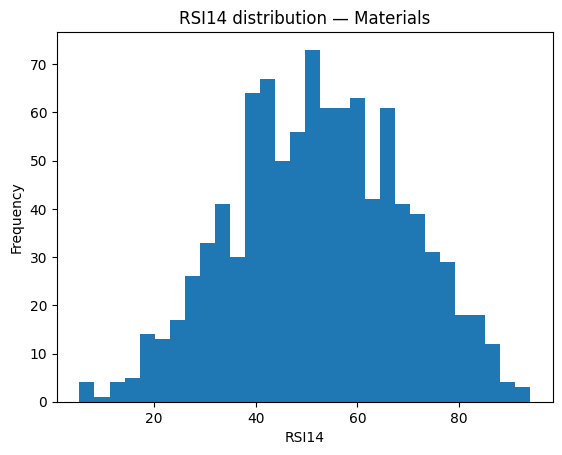

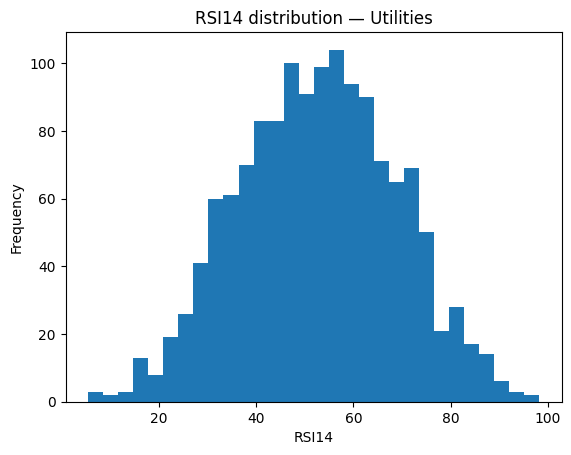

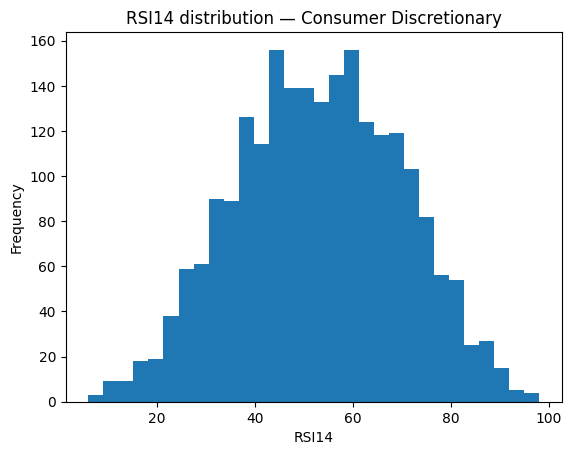

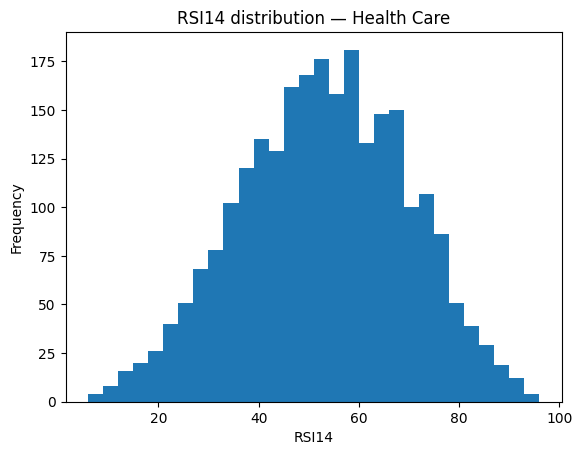

In [77]:
import matplotlib.pyplot as plt

# Распределение RSI по сектору
sample = master_fe.sample(20000, random_state=1)
for sec in sample["sector"].unique()[:4]:
    subset = sample[sample["sector"]==sec]
    plt.figure()
    plt.hist(subset["rsi14"].dropna(), bins=30)
    plt.title(f"RSI14 distribution — {sec}")
    plt.xlabel("RSI14")
    plt.ylabel("Frequency")
    plt.show()


In [10]:
# Построение и оценка базовой модели.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from pathlib import Path

# 1. Загрузка фич и мастер-даты
df = pd.read_parquet("data/processed/master_features.parquet")

# 2. Целевая переменная: знак next-day return
df = df.sort_values(["symbol","Date"])
df["ret_next1"] = df.groupby("symbol")["return"].shift(-1)
df.dropna(subset=["ret_next1"], inplace=True)
df["target_cls"] = (df["ret_next1"] > 0).astype(int)

# 3. Признаки (X) и цель (y)
feature_cols = [c for c in df.columns if c.startswith(("ret_lag","mom_","rsi","macd","sec_ret"))]
X_num = df[feature_cols]
y_cls = df["target_cls"]
y_reg = df["ret_next1"]

# 4. Добавим one-hot для сектора
# (sector уже дженерилось в master, но не входит в master_features; при желании можно добавить)
# encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
# sec_ohe = encoder.fit_transform(df[["sector"]])
#X = np.hstack([X_num.values, sec_ohe])

# 5. Разбиение по дате: train до 2023-01-01, test после
split_date = "2023-01-01"
train_idx = df["Date"] < split_date
test_idx  = df["Date"] >= split_date

X_train, X_test = X_num[train_idx], X_num[test_idx]
y_train_cls, y_test_cls = y_cls[train_idx], y_cls[test_idx]
y_train_reg, y_test_reg = y_reg[train_idx], y_reg[test_idx]

# 6. Стандартизируем числовые фичи
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 7a. Классификатор: LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_s, y_train_cls)
y_pred_cls = clf.predict(X_test_s)

acc  = accuracy_score(y_test_cls, y_pred_cls)
auc  = roc_auc_score(y_test_cls, clf.predict_proba(X_test_s)[:,1])
print("Classification accuracy:", round(acc, 4))
print("ROC AUC:              ", round(auc, 4))

# 7b. Регрессор: Ridge
reg = Ridge(alpha=1.0)
reg.fit(X_train_s, y_train_reg)
y_pred_reg = reg.predict(X_test_s)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2   = r2_score(y_test_reg, y_pred_reg)
print("Regression RMSE:", round(rmse, 6))
print("Regression R2:  ", round(r2, 4))


# 8. Сохраним результаты
res = pd.DataFrame({
    "y_true_cls": y_test_cls,
    "y_pred_cls": y_pred_cls,
    "y_true_reg": y_test_reg,
    "y_pred_reg": y_pred_reg
}, index=y_test_cls.index)
res.to_parquet("data/processed/predictions.parquet")
print("✓ predictions.parquet saved")


Classification accuracy: 0.5221
ROC AUC:               0.5033
Regression RMSE: 0.018216
Regression R2:   -0.0047
✓ predictions.parquet saved


In [11]:
# загрузим master_features с исходным индексом
master = pd.read_parquet("data/processed/master_features.parquet")

# загрузим predictions
res = pd.read_parquet("data/processed/predictions.parquet")

# «склеиваем» по индексу: в master попадут только тестовые строки
df_bt = master.join(
    res[["y_pred_cls", "y_true_reg"]],    # к master добавятся эти колонки
    how="inner"
)

# теперь df_bt содержит:
#   все колонки из master + y_pred_cls + y_true_reg
# в нём ровно те же строки, что и в predictions



In [14]:
df_bt["strat_ret"] = df_bt["y_pred_cls"] * df_bt["y_true_reg"]

# кумулятивная PnL
pnl = df_bt.groupby("Date")["strat_ret"].mean().cumsum()


Sharpe: 0.924


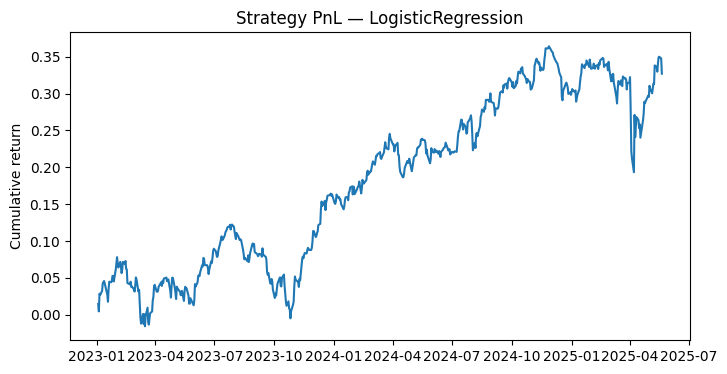

In [16]:
import numpy as np
import matplotlib.pyplot as plt

sharpe = pnl.diff().mean() / pnl.diff().std() * np.sqrt(252)
print("Sharpe:", round(sharpe,3))

plt.figure(figsize=(8,4))
plt.plot(pnl.index, pnl.values)
plt.title("Strategy PnL — LogisticRegression")
plt.ylabel("Cumulative return")
plt.show()


Sharpe strategy: 0.924


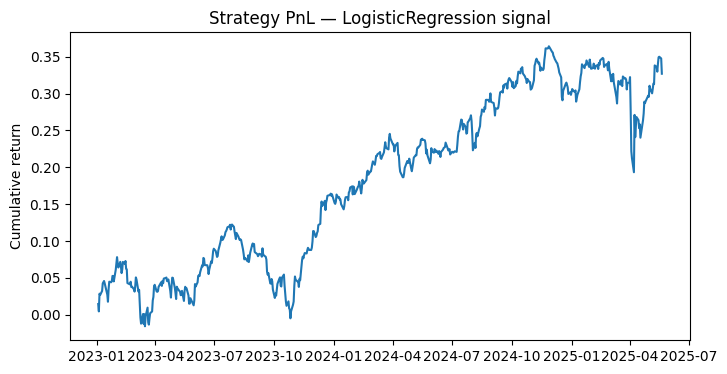

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Загрузим master_features (он уже хранит исходный индекс)
master = pd.read_parquet("data/processed/master_features.parquet")

# 2. Загрузим predictions
res = pd.read_parquet("data/processed/predictions.parquet")

# 3. «Склеим» их по индексу: в df_bt попадут только те строки, для которых есть прогноз
#    (т.е. ваша тестовая выборка)
df_bt = master.join(
    res[["y_pred_cls", "y_true_reg"]],
    how="inner"
)

# 4. Посчитаем PnL-стратегию: если модель прогнозирует up (1) — лонг, иначе flat
df_bt["strat_ret"] = df_bt["y_pred_cls"] * df_bt["y_true_reg"]

# 5. Кумулятивная PnL по датам
pnl = df_bt.groupby("Date")["strat_ret"].mean().cumsum()

# 6. Sharpe и график
sharpe = pnl.diff().mean() / pnl.diff().std() * np.sqrt(252)
print("Sharpe strategy:", round(sharpe, 3))

plt.figure(figsize=(8,4))
plt.plot(pnl.index, pnl.values)
plt.title("Strategy PnL — LogisticRegression signal")
plt.ylabel("Cumulative return")
plt.show()



In [20]:
# --- 0) Импорты ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# --- 1) Загрузка master-features ---
df = pd.read_parquet("data/processed/master_features.parquet")

# --- 2) Целевая переменная: sign of next-day return ---
df = df.sort_values(["symbol","Date"])
df["ret_next1"]   = df.groupby("symbol")["return"].shift(-1)
df.dropna(subset=["ret_next1"], inplace=True)
df["target_cls"]  = (df["ret_next1"] > 0).astype(int)

# --- 3) Фичи и целевые для классификации ---
feature_cols  = [c for c in df.columns if c.startswith(("ret_lag","mom_","rsi","macd","sec_ret"))]
X_num         = df[feature_cols]
y_cls         = df["target_cls"]

# --- 4) Сплит по дате ---
split_date    = "2023-01-01"
train_idx     = df["Date"] < split_date
test_idx      = df["Date"] >= split_date

X_train, X_test     = X_num.loc[train_idx], X_num.loc[test_idx]
y_train_cls, y_test_cls = y_cls.loc[train_idx], y_cls.loc[test_idx]

# --- 5) Стандартизация ---
scaler      = StandardScaler()
X_train_s   = scaler.fit_transform(X_train)
X_test_s    = scaler.transform(X_test)


In [22]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_dist = {
    "n_estimators":     [50, 100],
    "max_depth":        [None, 5, 10],
    "min_samples_leaf": [1, 3],
}

tscv = TimeSeriesSplit(n_splits=2)

hs = HalvingRandomSearchCV(
    rf,
    param_distributions=param_dist,
    cv=tscv,
    factor=2,
    scoring="roc_auc",
    random_state=42,
    verbose=2,
    n_jobs=-1,
)

hs.fit(X_train_s, y_train_cls)

print("Best params:", hs.best_params_)
print("CV ROC AUC: ", round(hs.best_score_, 4))



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 17
min_resources_: 8
max_resources_: 726406
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 8
Fitting 2 folds for each of 12 candidates, totalling 24 fits


/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=90800. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

----------
iter: 1
n_candidates: 6
n_resources: 16
Fitting 2 folds for each of 6 candidates, totalling 12 fits


/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/stocks/lib/py

----------
iter: 2
n_candidates: 3
n_resources: 32
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.36809524 0.54095238 0.44571429]
  warnings.warn(
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 1.         0.97596154 0.98076923]
  warnings.warn(


----------
iter: 3
n_candidates: 2
n_resources: 64
Fitting 2 folds for each of 2 candidates, totalling 4 fits


/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.36809524 0.54095238 0.44571429 0.4255102  0.43005566]
  warnings.warn(
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 1.         0.97596154 0.98076923 0.99659864 0.99659864]
  warnings.warn(


Best params: {'n_estimators': 50, 'min_samples_leaf': 3, 'max_depth': 10}
CV ROC AUC:  0.4301


In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 1. Предсказания вероятностей и классов
y_proba_rf = hs.predict_proba(X_test_s)[:,1]
y_pred_rf  = hs.predict(X_test_s)

# 2. Метрики
test_auc_rf  = roc_auc_score(y_test_cls, y_proba_rf)
test_acc_rf  = accuracy_score(y_test_cls, y_pred_rf)

print(f"RF Test ROC AUC:    {test_auc_rf:.4f}")
print(f"RF Test Accuracy:   {test_acc_rf:.4f}")


RF Test ROC AUC:    0.5031
RF Test Accuracy:   0.5203


In [24]:
# y_pred_rf и y_proba_rf у вас уже есть
res_rf = pd.DataFrame({
    "y_true_cls":    y_test_cls,
    "y_pred_cls_rf": y_pred_rf,
    "y_proba_rf":    y_proba_rf
}, index=y_test_cls.index)

res_rf.to_parquet("data/processed/pred_rf.parquet")
print("✓ pred_rf.parquet сохранён")


✓ pred_rf.parquet сохранён


RF Sharpe: 0.911


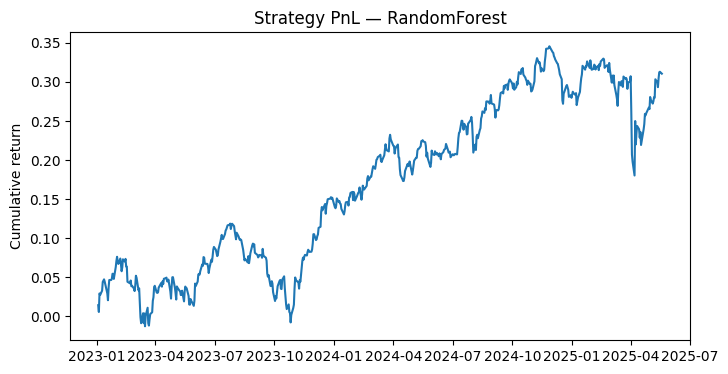

In [25]:
# 1) Загружаем master с фичами (с тем же индексом) и predictions
master = pd.read_parquet("data/processed/master_features.parquet")
res_rf  = pd.read_parquet("data/processed/pred_rf.parquet")

# 2) Join по индексу
df_bt = master.join(res_rf[["y_pred_cls_rf"]], how="inner")

# 3) Стратегия long, если y_pred_cls_rf == 1
#    используем ret_next1 (уже была в master или посчитаем ещё раз)
df_bt["ret_next1"] = df_bt.groupby("symbol")["return"].shift(-1)
df_bt["strat_ret"] = df_bt["y_pred_cls_rf"] * df_bt["ret_next1"]

# 4) Кумулятивный PnL
pnl = df_bt.groupby("Date")["strat_ret"].mean().cumsum()

import matplotlib.pyplot as plt
import numpy as np

# 5) Sharpe
sharpe = pnl.diff().mean() / pnl.diff().std() * np.sqrt(252)
print("RF Sharpe:", round(sharpe,3))

# 6) График
plt.figure(figsize=(8,4))
plt.plot(pnl.index, pnl.values)
plt.title("Strategy PnL — RandomForest")
plt.ylabel("Cumulative return")
plt.show()


In [26]:
pip


Usage:   
  /opt/anaconda3/envs/stocks/bin/python -m pip <command> [options]

Commands:
  install                     Install packages.
  lock                        Generate a lock file.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash        

In [27]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb

# 0. Загрузим датасет master_features с фичами
df = pd.read_parquet("data/processed/master_features.parquet")

# 1. Считаем целевку
df = df.sort_values(["symbol","Date"])
df["ret_next1"]   = df.groupby("symbol")["return"].shift(-1)
df.dropna(subset=["ret_next1"], inplace=True)
df["target_cls"]  = (df["ret_next1"] > 0).astype(int)

# 2. Выберем только числовые фичи (те же, что в логрегрессии)
feature_cols = [c for c in df.columns if c.startswith(("ret_lag","mom_","rsi","macd","sec_ret"))]
X = df[feature_cols]
y = df["target_cls"]

# 3. Разбиваем по дате
split_date = "2023-01-01"
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# 4. Стандартизация
scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform( X_test)

# 5. Приготовим RandomizedSearchCV  
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

param_dist_xgb = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [3, 5, 7],
    "learning_rate":    [0.01, 0.1, 0.2],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

tscv = TimeSeriesSplit(n_splits=3)

rs_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=tscv,
    scoring="roc_auc",
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# 6. Запускаем подбор (это займёт несколько минут)
rs_xgb.fit(X_train_s, y_train)

# 7. Смотрим результаты
print("XGB best params:", rs_xgb.best_params_)
print("XGB CV  ROC AUC:", round(rs_xgb.best_score_,4))

y_proba_xgb = rs_xgb.predict_proba(X_test_s)[:,1]
y_pred_xgb  = rs_xgb.predict(X_test_s)
print("XGB Test ROC AUC:",      round(roc_auc_score(y_test, y_proba_xgb),4))
print("XGB Test Accuracy:",     round(accuracy_score   (y_test, y_pred_xgb ),4))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:46:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:46:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:46:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:46:02] W

XGB best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGB CV  ROC AUC: 0.537
XGB Test ROC AUC: 0.5027
XGB Test Accuracy: 0.5149


In [28]:
print("Columns in df:", df.columns.tolist())


Columns in df: ['Date', 'symbol', 'price', 'return', 'sector', 'industry', 'ret_lag1', 'ret_lag5', 'ret_lag10', 'mom_5d', 'mom_10d', 'mom_20d', 'rsi14', 'ema12', 'ema26', 'macd', 'macd_sig', 'sec_ret5', 'ret_next1', 'target_cls']


In [29]:
# если symbol или Date — в индексе, поднимем их в колонки
master = master.reset_index()  
print("Now master columns:", master.columns.tolist())


Now master columns: ['index', 'Date', 'symbol', 'price', 'return', 'sector', 'industry', 'ret_lag1', 'ret_lag5', 'ret_lag10', 'mom_5d', 'mom_10d', 'mom_20d', 'rsi14', 'ema12', 'ema26', 'macd', 'macd_sig', 'sec_ret5']


In [30]:
# Проверьте колонки и первые строки
print("master_features columns:", master.columns.tolist())
print(master.head(), "\n")

print("profile.parquet columns:", profile.columns.tolist())
print(profile.head(), "\n")
print("profile shape:", profile.shape)


master_features columns: ['index', 'Date', 'symbol', 'price', 'return', 'sector', 'industry', 'ret_lag1', 'ret_lag5', 'ret_lag10', 'mom_5d', 'mom_10d', 'mom_20d', 'rsi14', 'ema12', 'ema26', 'macd', 'macd_sig', 'sec_ret5']
   index       Date symbol      price    return       sector  \
0     20 2015-02-02      A  35.555325  0.024358  Health Care   
1     21 2015-02-03      A  36.409977  0.024037  Health Care   
2     22 2015-02-04      A  35.941303 -0.012872  Health Care   
3     23 2015-02-05      A  36.327274  0.010739  Health Care   
4     24 2015-02-06      A  36.152672 -0.004806  Health Care   

                         industry  ret_lag1  ret_lag5  ret_lag10    mom_5d  \
0  Life Sciences Tools & Services -0.017941  0.008761   0.006314 -0.011050   
1  Life Sciences Tools & Services  0.024358 -0.010217  -0.008366  0.023205   
2  Life Sciences Tools & Services  0.024037 -0.019355   0.006064  0.029687   
3  Life Sciences Tools & Services -0.012872  0.012106   0.039046  0.028321   
4  

NameError: name 'profile' is not defined

In [ ]:
import pandas as pd

# 1) Загрузим master_features
df = pd.read_parquet("data/processed/master_features.parquet")

# 2) Восстановим следующий доход
df = df.sort_values(["symbol","Date"])
df["ret_next1"]   = df.groupby("symbol")["return"].shift(-1)

# 3) Целевая метка: 1, если ret_next1>0, иначе 0
df["target_cls"]  = (df["ret_next1"] > 0).astype(int)

# убедимся
print("Новых колонок:", "ret_next1" in df.columns, "target_cls" in df.columns)
print(df[["symbol","Date","return","ret_next1","target_cls"]].head(10))



In [ ]:
from sklearn.preprocessing import OneHotEncoder

# OHE сектора
ohe     = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
sec_enc = ohe.fit_transform(df[["sector"]])
sec_cols= [f"sector__{c}" for c in ohe.categories_[0]]
sec_df  = pd.DataFrame(sec_enc, columns=sec_cols, index=df.index)

# Признаки
feat_num = [c for c in df.columns if c.startswith(("ret_lag","mom_","rsi","macd","sec_ret"))]
X_num    = df[feat_num]
X        = pd.concat([X_num, sec_df], axis=1)
y        = df["target_cls"]


In [ ]:
# 3) One-Hot кодирование
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
sec_ohe = ohe.fit_transform(df[["sector"]])
sec_cols = [f"sector__{cat}" for cat in ohe.categories_[0]]
sec_df   = pd.DataFrame(sec_ohe, columns=sec_cols, index=df.index)

# 4) Собираем матрицу признаков
feature_cols = [c for c in df.columns if c.startswith(("ret_lag","mom_","rsi","macd","sec_ret"))]
X_num = df[feature_cols]
X     = pd.concat([X_num, sec_df], axis=1)
y     = df["target_cls"]

print("X shape:", X.shape)
print("y shape:", y.shape)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 1) Сплит по дате
split_date = "2023-01-01"
train_idx  = df["Date"] < split_date
test_idx   = df["Date"] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# 2) Стандартизация
scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3) Логрег
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_s, y_train)
y_pred   = clf.predict(X_test_s)
y_proba  = clf.predict_proba(X_test_s)[:,1]

print("Accuracy:",  round(accuracy_score(y_test,   y_pred),   4))
print("ROC AUC:",   round(roc_auc_score(y_test, y_proba), 4))


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train_s, y_train)
print("RF ROC AUC:", round(roc_auc_score(y_test, rf.predict_proba(X_test_s)[:,1]),4))


In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 1) Читаем master_features — там уже есть sector и industry
master  = pd.read_parquet("data/processed/master_features.parquet")

# 2) (Опционально) фундаментал
fund_file = "data/raw/fundamentals.parquet"
if os.path.exists(fund_file):
    fund = pd.read_parquet(fund_file).set_index("symbol")
    has_fund = True
else:
    print("⚠️ fundamentals.parquet не найден — пропускаем")
    fund = pd.DataFrame()
    has_fund = False

# 3) Собираем df из master (+ фундаментал, если есть)
df = master.copy()  # уже содержит 'sector' и 'industry'
if has_fund and not fund.empty:
    df = df.merge(fund, on="symbol", how="left")

# 4) OHE по industry (у df уже есть колонка industry)
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ind_mat = ohe.fit_transform(df[["industry"]])
ind_cols = [f"ind__{cat}" for cat in ohe.categories_[0]]
ind_df   = pd.DataFrame(ind_mat, columns=ind_cols, index=df.index)

# 5) Собираем X
num_feats = [c for c in df.columns if c.startswith(("ret_lag","mom_","rsi","macd","sec_ret"))]
X_num     = df[num_feats]

# Если есть числовые фундаментальные фичи,
# добавьте их сюда: 
#    fund_feats = ["peRatio", "debtEquity", …]
#    X_fund = df[fund_feats]
#    X = pd.concat([X_num, ind_df, X_fund], axis=1)

X = pd.concat([X_num, ind_df], axis=1)

# 6) Делаем y
df = df.sort_values(["symbol","Date"])
df["ret_next1"] = df.groupby("symbol")["return"].shift(-1)
df.dropna(subset=["ret_next1"], inplace=True)
y = (df["ret_next1"] > 0).astype(int)

# 7) Синхронизируем X и y по индексу
X = X.loc[y.index]

print("X.shape =", X.shape)
print("y.shape =", y.shape)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing  import StandardScaler

split_date = "2023-01-01"
train_idx  = df["Date"] <  split_date
test_idx   = df["Date"] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing  import StandardScaler

# 1.1 сформируем train/test по дате
split_date = "2023-01-01"
train_idx  = df["Date"] <  split_date
test_idx   = df["Date"] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# 1.2 стандартизуем
scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics   import accuracy_score, roc_auc_score

# 2.1 обучаем
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)

# 2.2 метрики на тесте
y_proba = rf.predict_proba(X_test_s)[:,1]
y_pred  = rf.predict(X_test_s)

print("RF Test ROC AUC:   ", round(roc_auc_score(y_test, y_proba),4))
print("RF Test Accuracy:  ", round(accuracy_score(y_test, y_pred),4))


In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

param_dist = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [None, 5, 10],
    "min_samples_leaf": [1, 3],
}

tscv = TimeSeriesSplit(n_splits=3)
hs = HalvingRandomSearchCV(
    rf,
    param_distributions=param_dist,
    cv=tscv,
    factor=2,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
    n_jobs=-1
)

hs.fit(X_train_s, y_train)
print("Best RF params:", hs.best_params_)
print("Best RF CV AUC:", round(hs.best_score_,4))

# финальная проверка
y_proba_tuned = hs.predict_proba(X_test_s)[:,1]
y_pred_tuned  = hs.predict(X_test_s)
print("Tuned RF Test ROC AUC:", round(roc_auc_score(y_test, y_proba_tuned),4))
print("Tuned RF Test Accuracy:", round(accuracy_score(y_test, y_pred_tuned),4))


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

param_dist_xgb = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [3, 5, 7],
    "learning_rate":    [0.01, 0.1, 0.2],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

rs_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=tscv,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
    n_jobs=-1
)
rs_xgb.fit(X_train_s, y_train)

print("XGB best params:", rs_xgb.best_params_)
print("XGB CV AUC:", round(rs_xgb.best_score_,4))

y_proba_xgb = rs_xgb.predict_proba(X_test_s)[:,1]
y_pred_xgb  = rs_xgb.predict(X_test_s)
print("XGB Test ROC AUC:  ", round(roc_auc_score(y_test, y_proba_xgb),4))
print("XGB Test Accuracy: ", round(accuracy_score(y_test, y_pred_xgb),4))


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# даты уже в df["Date"]
split_date = "2023-01-01"
train_idx  = df["Date"] <  split_date
test_idx   = df["Date"] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics   import roc_auc_score, accuracy_score

rf = RandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=3,
    random_state=42, n_jobs=-1
)
rf.fit(X_train_s, y_train)

y_proba = rf.predict_proba(X_test_s)[:,1]
y_pred  = rf.predict(X_test_s)
print("RF ROC AUC:",  round(roc_auc_score(y_test, y_proba),4))
print("RF Acc:",      round(accuracy_score(y_test, y_pred),4))


In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection   import HalvingRandomSearchCV
from xgboost                  import XGBClassifier

xgb_clf = XGBClassifier(
    objective="binary:logistic", eval_metric="auc",
    use_label_encoder=False, random_state=42, n_jobs=-1
)

param_dist = {
    "n_estimators":     [50,100,200],
    "max_depth":        [3,5,7],
    "learning_rate":    [0.01,0.1],
    "subsample":        [0.6,0.8,1.0],
    "colsample_bytree": [0.6,0.8,1.0]
}

tscv = TimeSeriesSplit(n_splits=3)
hs   = HalvingRandomSearchCV(
    xgb_clf, param_dist,
    cv=tscv, factor=2,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
    n_jobs=-1
)

hs.fit(X_train_s, y_train)
print("Best XGB params:", hs.best_params_)
print("CV ROC AUC:",     round(hs.best_score_,4))

# финальная проверка на тесте
y_proba_xgb = hs.predict_proba(X_test_s)[:,1]
y_pred_xgb  = hs.predict(X_test_s)
print("XGB Test ROC AUC:",  round(roc_auc_score(y_test, y_proba_xgb),4))
print("XGB Test Acc:",      round(accuracy_score(y_test, y_pred_xgb),4))


In [ ]:
import pandas as pd

# допустим, вы уже вычислили y_pred_xgb и y_proba_xgb, и у вас есть test-маска:
#    y_proba_xgb = hs.predict_proba(X_test_s)[:,1]
#    y_pred_xgb  = hs.predict(X_test_s)
#    test_idx    = df["Date"] >= "2023-01-01"

# 1) Собираем DataFrame с предсказаниями
res_xgb = pd.DataFrame({
    "y_pred_cls_xgb": y_pred_xgb,
    "y_proba_xgb":    y_proba_xgb
}, index=df.loc[test_idx].index)

# 2) Сохраняем его
res_xgb.to_parquet("data/processed/pred_xgb.parquet")
print("✓ pred_xgb.parquet сохранён")


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# 3) Загружаем мастер и предсказания
master = pd.read_parquet("data/processed/master_features.parquet")
res_xgb = pd.read_parquet("data/processed/pred_xgb.parquet")

# 4) Склеиваем по индексу
df_bt = master.join(res_xgb, how="inner")

# 5) Считаем следующий день и стратегическую доходность
df_bt = df_bt.sort_values(["symbol","Date"])
df_bt["ret_next1"] = df_bt.groupby("symbol")["return"].shift(-1)
df_bt["strat_ret"] = df_bt["y_pred_cls_xgb"] * df_bt["ret_next1"]

# 6) Кумулятивная PnL и Sharpe
pnl    = df_bt.groupby("Date")["strat_ret"].mean().cumsum()
sharpe = pnl.diff().mean() / pnl.diff().std() * np.sqrt(252)

print("XGB strategy Sharpe:", round(sharpe,3))
plt.figure(figsize=(8,4))
plt.plot(pnl.index, pnl.values)
plt.title("XGB Strategy PnL")
plt.ylabel("Cumulative return")
plt.show()


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# 3) Загружаем мастер и предсказания
master = pd.read_parquet("data/processed/master_features.parquet")
res_xgb = pd.read_parquet("data/processed/pred_xgb.parquet")

# 4) Склеиваем по индексу
df_bt = master.join(res_xgb, how="inner")

# 5) Считаем следующий день и стратегическую доходность
df_bt = df_bt.sort_values(["symbol","Date"])
df_bt["ret_next1"] = df_bt.groupby("symbol")["return"].shift(-1)
df_bt["strat_ret"] = df_bt["y_pred_cls_xgb"] * df_bt["ret_next1"]

# 6) Кумулятивная PnL и Sharpe
pnl    = df_bt.groupby("Date")["strat_ret"].mean().cumsum()
sharpe = pnl.diff().mean() / pnl.diff().std() * np.sqrt(252)

print("XGB strategy Sharpe:", round(sharpe,3))
plt.figure(figsize=(8,4))
plt.plot(pnl.index, pnl.values)
plt.title("XGB Strategy PnL")
plt.ylabel("Cumulative return")
plt.show()


In [ ]:
param_dist_xgb = {
    "n_estimators":     [50, 100, 200],
    "max_depth":        [3,  5,   7],
    "learning_rate":    [0.01, 0.1, 0.2],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}


In [52]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",    # обязательно строкой
    eval_metric="logloss",          # на основании чего XGB считает loss
    use_label_encoder=False,        # для новых версий
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

rs_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=tscv,
    scoring="roc_auc",
    random_state=42,
    verbose=2,
    n_jobs=-1,
    error_score="raise"             # чтобы увидеть реальные ошибки сразу
)

# X_train_s и y_train уже должны быть без пропусков и с правильными размерами
rs_xgb.fit(X_train_s, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:50:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:50:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:50:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/stocks/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:50:09] W

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [54]:
print("XGB best params:", rs_xgb.best_params_)
print("XGB CV  ROC AUC:", round(rs_xgb.best_score_,4))


XGB best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGB CV  ROC AUC: 0.537


In [56]:
# Предсказания
y_proba = rs_xgb.predict_proba(X_test_s)[:,1]
y_pred  = rs_xgb.predict(X_test_s)

# Метрики
from sklearn.metrics import roc_auc_score, accuracy_score
print("Test ROC AUC:     ", round(roc_auc_score(y_test,    y_proba),4))
print("Test Accuracy:    ", round(accuracy_score(y_test,   y_pred),4))


Test ROC AUC:      0.5027
Test Accuracy:     0.5149


XGB strategy Sharpe: 1.02


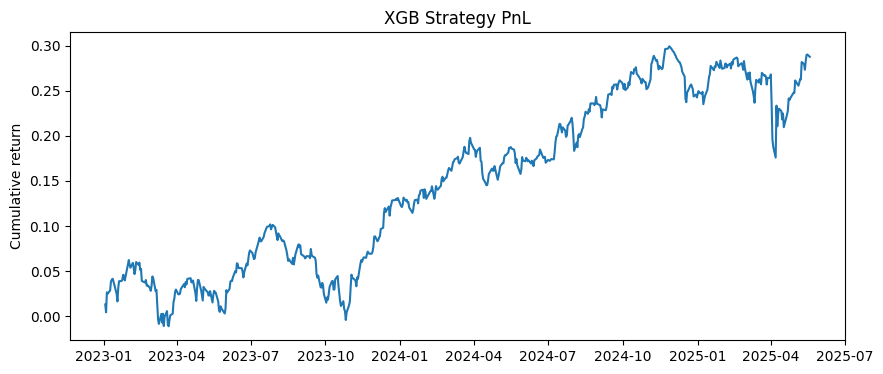

In [58]:
# 1) Сохраним predictions
import pandas as pd
res = pd.DataFrame({
    "y_pred_cls_xgb": y_pred,
    "y_proba_xgb":   y_proba
}, index=y_test.index)
res.to_parquet("data/processed/predictions_xgb.parquet")

# 2) Сборка датасета для бэктеста
master = pd.read_parquet("data/processed/master_features.parquet")
df_bt  = master.join(res, how="inner").sort_values(["symbol","Date"])
df_bt["ret_next1"] = df_bt.groupby("symbol")["return"].shift(-1)
df_bt["strat_ret"] = df_bt["y_pred_cls_xgb"] * df_bt["ret_next1"]

# 3) Кумулятивная PnL и Sharpe
pnl    = df_bt.groupby("Date")["strat_ret"].mean().cumsum()
sharpe = pnl.diff().mean() / pnl.diff().std() * np.sqrt(252)

print("XGB strategy Sharpe:", round(sharpe,3))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(pnl.index, pnl.values)
plt.title("XGB Strategy PnL")
plt.ylabel("Cumulative return")
plt.show()


ret_lag5     0.122225
ret_lag1     0.120205
ret_lag10    0.117376
mom_5d       0.117314
mom_20d      0.110560
mom_10d      0.108428
macd_sig     0.106194
rsi14        0.103970
macd         0.093728
sec_ret5     0.000000
dtype: float32


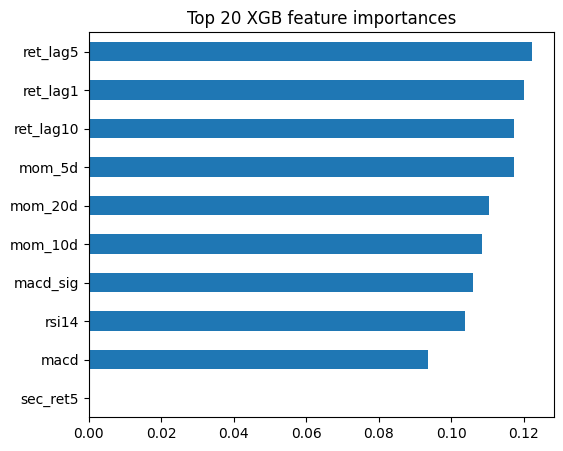

In [60]:
import pandas as pd
imp = pd.Series(
    rs_xgb.best_estimator_.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Топ-10
print(imp.head(10))

# График
imp.head(20).plot.barh(figsize=(6,5), title="Top 20 XGB feature importances")
plt.gca().invert_yaxis()
plt.show()


In [76]:
# вместо merge с profile, просто скопируем master — в нём уже есть колонка industry
df = master.copy()


In [78]:
profile_full = pd.read_parquet("data/processed/profile.parquet")  # здесь — sector+industry
df = master.merge(profile_full[["symbol","industry"]], on="symbol", how="left")


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/profile.parquet'

In [80]:
master = pd.read_parquet("data/processed/master_features.parquet")
df     = master.copy()   # тут уже есть и `sector`, и `industry`


In [84]:
master       = pd.read_parquet("data/processed/master_features.parquet")
profile_full = pd.read_parquet("data/raw/profile.parquet")   # <-- вот он!
df           = master.merge(
    profile_full[["symbol","industry"]],
    on="symbol",
    how="left"
)


In [86]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

lgb = LGBMClassifier(random_state=42, n_jobs=-1)
param_dist = {
    "n_estimators":    [100,200,500],
    "learning_rate":   [0.01,0.05,0.1],
    "max_depth":       [3,5,8,None],
    "num_leaves":      [15,31,63],
    "subsample":       [0.6,0.8,1.0],
    "colsample_bytree":[0.6,0.8,1.0],
}
tscv = TimeSeriesSplit(n_splits=3)
rs = RandomizedSearchCV(
    lgb, param_distributions=param_dist, n_iter=30,
    cv=tscv, scoring="roc_auc", n_jobs=-1, random_state=42, verbose=2
)
rs.fit(X_train, y_train)
print("LGB best params:", rs.best_params_)
print("LGB CV AUC:",    rs.best_score_)
y_p = rs.predict_proba(X_test)[:,1]
print("Test AUC:",       roc_auc_score(y_test, y_p))


ModuleNotFoundError: No module named 'lightgbm'

In [92]:
# mask, X и y вы уже формировали так:
mask = y.notna()
df_masked = df.loc[mask]   # df со всеми нужными колонками, только по тем же индексам, что и X, y

# 1) Сплитим df_masked по дате
split_date = "2023-01-01"
train_idx = df_masked.index[df_masked["Date"] <  split_date]
test_idx  = df_masked.index[df_masked["Date"] >= split_date]

# 2) Теперь режем X и y ровно по этим индексам
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).